In [31]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START, add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, BaseMessage

In [32]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

In [33]:
class ChatbotState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [34]:
def chatnode(state: ChatbotState):

    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [35]:
graph = StateGraph(ChatbotState)

graph.add_node("chatnode",chatnode)

graph.add_edge(START, "chatnode")
graph.add_edge("chatnode",END)

workflow = graph.compile()

In [ ]:
while True:

    question = input("Ask me:")
    print(question)
    if question.lower().strip() in ["quit","exit"]:
        print("Ending, the chat.....")
        break
    else:

        reaponse = workflow.invoke({"messages": [HumanMessage(content=question)]})
        print(reaponse)

hii
{'messages': [HumanMessage(content='hii', additional_kwargs={}, response_metadata={}, id='dcb5be34-bb56-4e35-b4a3-0d652a3ae666'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--152bf1dc-e0c3-4252-84d2-75b0989837a9-0')]}
how are you


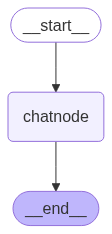

In [11]:
workflow